MAP fitter for RFI time series. Heavily WIP.

In [350]:
##Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from SSINS import INS
import os
import scipy.linalg as la
from scipy.signal.windows import dpss
from scipy.optimize import minimize
from itertools import combinations

In [351]:
##Defining two important functions -- the frequency channel selection and averaging functions.

def chan_select(ins, chan_name, shape_dict):

    """
    The frequency channel selection function. Also used to apply masks to your data.

    Args
    -----
    ins:
        INS object to be filtered.
    chan_name:
        channel name from shape dictionary
    shape_dict:
        shape dictionary by which you've divided and labelled the frequency array

    Returns
    -------
    ins_subband:
        INS object whose metric array is the filtered metric array without masks.
    masked_ins:
        INS object whose metric array is the filtered metric array with masks.
    N_bl:
        number of baselines.
    N_freq:
        number of frequencies.
    """

    #Creating band selection mask
    freq_mask = (ins.freq_array >= shape_dict[chan_name][0]) & (ins.freq_array <= shape_dict[chan_name][1])
    subband_chans = np.where(freq_mask)[0]
    N_freq = len(subband_chans)

    #Generating selected subband array
    ins_subband = ins.copy()
    ins_subband.select(freq_chans=subband_chans)
    N_bl = np.max(ins_subband.weights_array)

    #Masking
    masked_ins = ins_subband.copy()
    mask_array = ins_subband.mask_to_flags()[1:]
    masked_data = np.copy(ins_subband.metric_array)
    masked_data[mask_array] = np.nan
    masked_ins.metric_array = masked_data
    
    #Getting rid of the pesky subband lines
    line_mask = np.load('Data/linemask.npy')[subband_chans]
    ins_subband.metric_array = ins_subband.metric_array[:, ~line_mask, :]
    ins_subband.freq_array = ins_subband.freq_array[~line_mask]
    masked_ins.metric_array = masked_ins.metric_array[:, ~line_mask, :]
    masked_ins.freq_array = masked_ins.freq_array[~line_mask]

    return ins_subband, masked_ins, N_bl, N_freq


def chan_avg(ins):

    """
    The frequency channel averaging function. Averages the metric array over the frequency axis.

    Args
    ----
    ins:
        INS object to be averaged.

    Returns
    -------
    time_filtered:
        Clean time series.
    freq_averaged:
        Clean and frequency-averaged metric array.
    """
    
    #Calling time and amplitudes, filtering out infs and NaNs by mapping them to -1.
    time = np.array(ins.time_array)
    data = np.array(ins.metric_array[:, :, 0])
    data[~np.isfinite(data)] = -1

    #Averaging over full band/subband per integration
    freq_averaged = np.mean(data, axis=1)

    #Filtering out zeroes
    non_zero_mask = freq_averaged > 0
    time_filtered = time[non_zero_mask]
    freq_averaged = freq_averaged[non_zero_mask]

    return time_filtered, freq_averaged



In [352]:
##Importing data file from Data folder

#Defining the data directory and night in file name
data_dir = "Data"
night = "109337_p2"

#Constructing datapath and constructing ins object using SSINS
datapath = os.path.join(data_dir, night + "_SSINS_data.h5")
maskpath = os.path.join(data_dir, night + "_SSINS_mask.h5")
ins = INS(datapath, telescope_name='MWA', mask_file=maskpath)

#Defining shape dictionary
TV_dict = {
    'TV6': [1.74e8, 1.81e8],
    'TV7': [1.81e8, 1.88e8],
    'TV8': [1.88e8, 1.95e8],
    'TV9': [1.95e8, 2.02e8]
    }

#Selecting one DTV subband
chan_name = 'TV7'

#Extracting and averaging over the selected subband
ins_subband, masked_ins, N_bl, N_freq = chan_select(ins, chan_name, TV_dict)
time, amp = chan_avg(ins_subband)
masked_time, masked_amp = chan_avg(masked_ins)

invalid value encountered in multiply
invalid value encountered in divide
sig_array has been reset


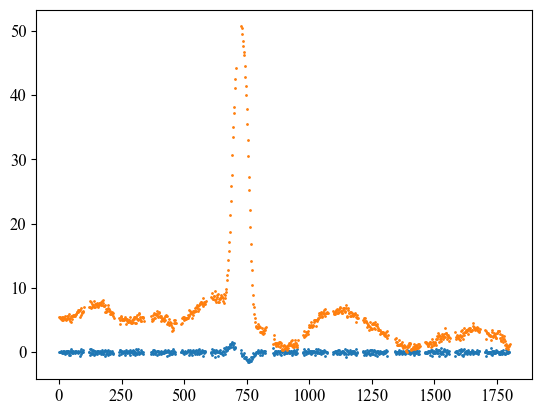

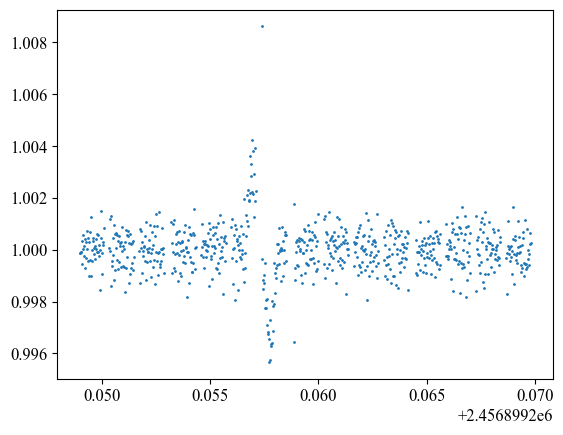

In [ ]:
#Some auxiliary code for plotting time series that I've been working with

plt.scatter((time[1:]-time[1])*24*60*60, np.diff(amp)/(np.diff(time)*24*60*60), s=1)
plt.scatter((time[0:]-time[0])*24*60*60, amp - np.min(amp), s=1)
plt.show()

plt.scatter(time[1:], amp[1:]/amp[:-1], s=1)

In [354]:
##Previous data for constructing prior on RFI emission parameters

#Peaks, SSINS amplitudes (arb units)
peaks=np.array([53.35432366, 8.97030183, 39.32910956, 28.3103236, 30.93772398, 36.2624972, 15.55913153, 44.21889192,
       44.9823896, 36.18116225, 25.08418434, 33.37233714, 51.98871383, 71.11015838, 25.76393398, 17.09304232, 
       6.0885566, 11.14962293, 52.29949963, 44.91604231, 23.85311619, 57.59864797, 1.21500878e+01, 4.57578285e+01,
       43.16161392, 51.0379999, 16.44774823, 53.31619823, 85.09920858, 10.72147938, 18.26272233, 37.61133042,
       11.1810082, 12.82857739, 51.49711535, 20.3400262, 34.50876787, 46.37546283, 35.81477314, 36.96341681,
       9.18631159, 33.3049884, 6.10809826, 18.75778949, 26.21931248, 46.57467886, 22.82709187, 18.69584422,
       56.140001, 66.05041274, 61.65063534, 5.5279846, 7.64796047, 59.34091678, 63.71339591, 38.23994538])


#Time into pointing/length of pointing -- want flat
loc=np.array([0.39361857, 0.94595976, 0.52309947, 0.1174075, 0.42087645, 0.55030397, 0.96448721, 0.95354939,
     0.5667833, 0.9647058, 0.13256501, 0.52036559, 0.18725956, 0.53959978, 0.81926798, 0.85710116, 
     0.19789189, 0.56327705, 0.62144842, 0.11526984, 0.44578389, 0.15972674, 1.84629939e-01, 8.81903585e-01,
     2.53746154e-01, 3.52378053e-01, 6.56658287e-01, 0.20640947, 0.9842502, 0.82448753, 0.79864468, 0.82609582,
     0.11022169, 0.07753185, 0.57244621, 0.0896191, 0.64090821, 0.4027631, 0.24795562, 0.72001842,
     0.10122139, 0.25738608, 0.64577568, 0.68554986, 0.45178244, 0.82402821, 0.16167855, 0.25189232,
     0.45948544, 0.53000544, 0.94603795, 0.41958575, 0.94060631, 0.4551634, 0.96417559, 0.68670813])

#Durations (s)
widths=np.array([46.35740966, 47.78082138, 52.01985143, 51.1243677, 48.66579981, 62.63576724, 51.55184647, 64.54810228,
        68.97618067, 63.08569669, 56.8891352, 64.68566024, 54.74073774, 57.955234, 35.92143505, 32.08070818,
        74.16922759, 57.12015228, 69.59804093, 65.70437593, 47.97567077, 82.01174163, 6.44723034e+01, 6.44048269e+01,
        6.87384350e+01, 6.99024843e+01, 5.66360677e+01, 73.41190595, 97.88771772, 38.34149624, 40.48260042, 62.84866352,
        39.34094184, 43.88357933, 68.20029216, 55.17499495, 59.64828645, 65.16642306, 59.59367969, 57.69014685,
        39.30030286, 25.61981977, 60.45653745, 36.25104968, 50.26782436, 66.64052355, 64.69421242, 35.47301949,
        57.35702717, 62.72083288, 57.83072425, 72.39670654, 7.68408292e+01, 56.47607773, 58.60065642, 58.92762818])


widths = np.sort(widths)/60/60/24   #Rescaling to Julian time units
loc = np.sort(loc)
peaks = np.sort(peaks)

#Constructing our prior sample matrix
theta_0 = np.vstack((peaks, loc*(np.max(time) - np.min(time)), widths))

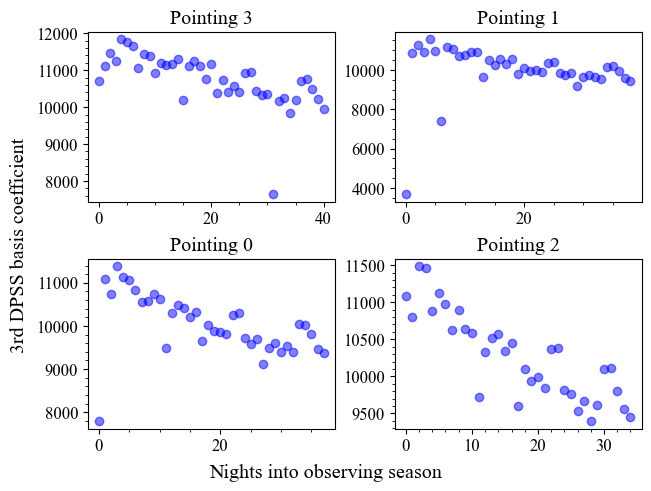

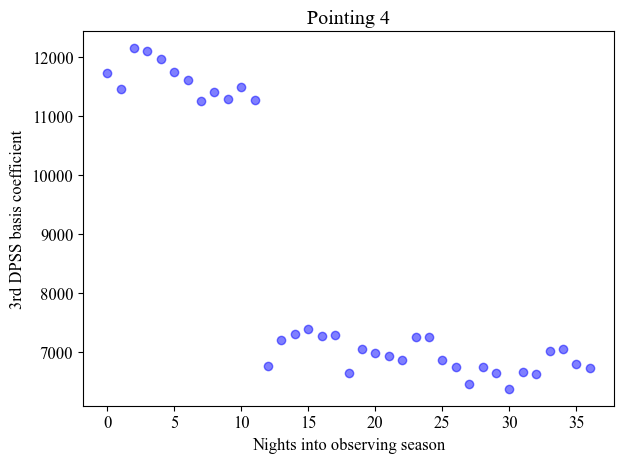

[array([11640871.45938947]), np.int32(2), array([1., 1.]), np.float64(9.103828801926284e-15)]


In [ ]:
##Constructing our DPSS fit coefficient prior

c0 = np.load('Data/p0_coefficients.npy')
c1 = np.load('Data/p1_coefficients.npy')
c2 = np.load('Data/p2_coefficients.npy')
c3 = np.load('Data/p3_coefficients.npy')
c4 = np.load('Data/p4_coefficients.npy')

samples = np.concatenate((c0, c1, c2, c3))


##Defining our subplots -- one at a time
fig, ax = plt.subplots(ncols=2, nrows=2, constrained_layout=True)
ax[0, 0].minorticks_on()
ax[1, 0].minorticks_on()
ax[0, 1].minorticks_on()
ax[1, 1].minorticks_on()

ax[0, 0].scatter(np.arange(len(c3[::4])), c3[:, 2][::4], alpha=0.5, label='p3', color='blue')
ax[0, 0].set_title("Pointing 3")
poly_design = np.vander(np.arange(len(c3))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c3[:, 2][::4]
res = c3[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[0, 0].plot(np.arange(len(c3))[::4], poly_design @ poly_fit)
#ax[0, 0].fill_between(np.arange(len(c3))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)

ax[0, 1].scatter(np.arange(len(c1[::4])), c1[:, 2][::4], alpha=0.5, label='p1', color='blue')
ax[0, 1].set_title("Pointing 1")
poly_design = np.vander(np.arange(len(c1))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c1[:, 2][::4]
res = c1[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[0, 1].plot(np.arange(len(c1))[::4], poly_design @ poly_fit)
#ax[0, 1].fill_between(np.arange(len(c1))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)


ax[1, 0].scatter(np.arange(len(c0[::4])), c0[:, 2][::4], alpha=0.5, label='p0', color='blue')
ax[1, 0].set_title("Pointing 0")
poly_design = np.vander(np.arange(len(c0))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c0[:, 2][::4]
res = c0[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[1, 0].plot(np.arange(len(c0))[::4], poly_design @ poly_fit)
#ax[1, 0].fill_between(np.arange(len(c0))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)


ax[1, 1].scatter(np.arange(len(c2[::4])), c2[:, 2][::4], alpha=0.5, label='p2', color='blue')
ax[1, 1].set_title("Pointing 2")
poly_design = np.vander(np.arange(len(c2))[::4], 2, increasing=True)
poly_fit = la.inv(poly_design.T @ poly_design) @ poly_design.T @ c2[:, 2][::4]
res = c2[:, 2][::4] - poly_design @ poly_fit
sigma_p = np.sum(res**2)/(len(res) - 2) * la.inv(poly_design.T @ poly_design)
sigma_f = poly_design @ sigma_p @ poly_design.T
#ax[1, 1].plot(np.arange(len(c2))[::4], poly_design @ poly_fit)
#ax[1, 1].fill_between(np.arange(len(c2))[::4], -np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, np.diag(np.sqrt(sigma_f)) + poly_design @ poly_fit, alpha=0.3)


#plt.scatter(np.arange(len(c4))[::4], c4[:, 2][::4], alpha=0.5, label='p4')
fig.supxlabel('Nights into observing season')
fig.supylabel('3rd DPSS basis coefficient')
plt.show()


plt.scatter(np.arange(len(c4[::4])), c4[:, 2][::4], alpha=0.5, label='p2', color='blue')
plt.title("Pointing 4")
plt.xlabel('Nights into observing season')
plt.ylabel('3rd DPSS basis coefficient')
plt.tight_layout()
plt.show()


#line_fit, opt = np.polynomial.Polynomial.fit(np.arange(len(c3))[::4], c3[:, 2][::4], 1, full=True)
#print(opt)

#plt.scatter(np.arange(len(c4))[::4], c4[:, 2][::4], alpha=0.5)
#plt.show()

In [ ]:
##Defining the crown jewel of this entire notebook, the objective posterior function

##Constructing a uniform time axis
dt = st.mode(np.diff(time)).mode
smooth_time = np.arange(time.min(), time.max() + dt, dt)

##Constructing a padded uniform amplitude grid
padded_amp = np.full_like(smooth_time, np.nan, dtype=float)
indices = np.searchsorted(smooth_time, time)
padded_amp[indices] = amp


#The definition of the objective function
def rcos_diff(params, time, vis_amp, show_converg=False, penalty=5000):

    """ 
    The objective log-posterior function for MAP fitting of the SSINS time series

    Args
    ----

    params:
        Concatenated numpy array of DPSS coefficients + emission coefficients. Of the form (13 + 3*num_emissions, ).
        The emission coefficients are ordered as [peaks, loc, width]*num_emissions.as_integer_ratio

    time:
        Uniform time array.
    
    vis_amp:
        Uniform amplitude array.
    
    show_converg:
        Boolean. If True, the objective posterior will print the posterior throughout minimization.
    
    penalty:
        Penalty factor that penalizes high emission numbers. 
        Future step: properly define this to give the Poisson distribution for airplane emissions.

    
    Returns
    -------

    minus_posterior:
        Minus the log posterior, the value which we want to minimize.

      """

    #Defining the number of DPSS terms
    N_terms=20

    #Making our DPSS fit coefficients and emission parameters
    coeff = params[:N_terms]
    theta = params[N_terms:]
    
    #Constructing our DPSS basis
    NW, K = 4, N_terms
    design = dpss(len(time), NW, K).T
    background = design @ coeff

    #Building our emissions
    emission = np.zeros_like(time)
    if len(theta) > 0:
        num_emissions = len(theta) // 3
    else:
        num_emissions = 0

    if len(theta) % 3 != 0:
        raise ValueError("Incorrect array size for Gaussian fit parameters.")

    for k in range(num_emissions):
        amp, mu, sigma = theta[3*k : 3*k + 3]
        mask = np.abs(time - mu) <= sigma
        emission[mask] += amp / 2 * (1 + np.cos(np.pi*(time[mask] - mu)/sigma))

    #Defining the joint model
    amp_fit = background + emission

    #Defining our residuals
    mask = np.isfinite(vis_amp)
    mod_res = amp_fit[mask] - vis_amp[mask]
    
    #Constructing the noise:
    C = 4/np.pi - 1
    noise_var = (amp_fit[mask]**2) * C / (N_bl * N_freq) + 1e-5

    #Now we can build our log likelihood:
    log_like = -0.5 * (
        np.sum(mod_res**2 / noise_var) +  # Quadratic term
        np.sum(np.log(noise_var)) +         # Log determinant
        len(mod_res) * np.log(2*np.pi)    # Normalization
    )


    #Determining prior mean and covariance for DPSS coefficients
    prior_mean = np.mean(samples, axis=0)
    prior_cov = np.cov(samples.T)
    
    prior_residual = coeff[:13] - prior_mean
    
    
    # Full prior construction for coefficients
    L = la.cholesky(prior_cov, lower=True)
    alpha = la.solve_triangular(L, prior_residual, lower=True)
    log_prior_coeff = -0.5 * (
        alpha @ alpha +
        2 * np.sum(np.log(np.diag(L))) +
        13 * np.log(2*np.pi)
    )

    
    #Determining prior mean and covariance for emission coefficients
    emit_mean = np.mean(theta_0[[0, 2]], axis=1)
    emit_cov = la.block_diag(*[np.cov(theta_0[[0, 2]])] * num_emissions)

    mask = np.arange(len(theta)) % 3 != 1
    emit_residual = theta[mask] - np.tile(emit_mean, num_emissions)

    # Full prior construction for emission parameters
    if num_emissions>0:
        L = la.cholesky(emit_cov, lower=True)
        alpha = la.solve_triangular(L, emit_residual, lower=True)
        log_prior_emit = -0.5 * (
            alpha @ alpha +
            2 * np.sum(np.log(np.diag(L))) +
            len(theta) * np.log(2*np.pi)
        )
    else:
        log_prior_emit=0

    #Defining minus the log posterior, the output of our objective function
    minus_posterior = -(log_like + log_prior_coeff + log_prior_emit) + penalty*num_emissions

    #Prints the value of the objective function if set to True
    if show_converg==True:
        print(-(log_like + log_prior_coeff + log_prior_emit))


    return minus_posterior

In [357]:
##The core of the MAP fitter. Iterates across a preset range of emission numbers, probing to find the best fit.
##To prevent us from falling into local minima, the grid seeding allows us to identify the location of the global minimum quickly.

#Translating time axis to start at 0 to make convergence easier
smooth_time = smooth_time - np.min(smooth_time[np.isfinite(smooth_time)])

#Setting the number of DPSS terms
N_terms=20

#Initializes minimum objective function for our probing and corresponding fit
min_prob = 1e9
min_fit = 0
emit_test_range = 1

#Constructing the emissions looper
for num_emissions in range(1, emit_test_range+1):

    print(f"Testing {num_emissions} emissions.")

    #initializing log probability and fits
    log_prob = np.array([])
    time_fits = np.empty((0, N_terms + 3*num_emissions))

    #Constructing the divisions/seeds in the time grid
    divs = 12
    seeds = np.linspace(smooth_time.min(), smooth_time.max(), divs)

    #Constructing the combinations of seeds we can construct using num_emissions
    combos = np.array(list(combinations(seeds, num_emissions)))
    print("Number of seeds:", len(combos))

    #Constructing the grid seed for loop
    for x in range(len(combos)):

        #Running through the combinations
        print(f"Running cycle #{x+1}...")

        #Constructing our initial guess of emission parameters based on our seeds
        emit_array = []
        for j in np.arange(0, num_emissions):
            emit_array = np.concatenate((emit_array, [np.mean(theta_0[0]), combos[x, j], np.mean(theta_0[2])]))
        
        #Initial guess (DPSS coeffs + emit params)
        p0 = np.concatenate((np.mean(samples, axis=0), np.zeros(shape=(N_terms-13, )), emit_array))

        #Bounds -- in the case of the time loc for emissions, this also implements a flat prior
        bounds = (
            [(-1e5, 1e5)] * N_terms +
            ([(theta_0[0].min(), theta_0[0].max()), (0, smooth_time.max()), (theta_0[2].min(), smooth_time.max())] * num_emissions)
        )

        #Minimizing and probing using Nelder-Mead optimization
        rcos_fit = minimize(
            lambda p: rcos_diff(p, smooth_time, padded_amp),
            x0=p0,
            bounds=bounds,
            method='Nelder-Mead',
            options={
                'maxfev': 500,
                'adaptive': True,  
                'xatol': 1e-6,     
                'fatol': 1e-5
            }
        ).x

        #Constructing objective function values
        log_prob_min = rcos_diff(rcos_fit, smooth_time, padded_amp)
        log_prob = np.append(log_prob, log_prob_min)
        time_fits = np.vstack([time_fits, rcos_fit])

    #Estimating location of global minimum
    rcos_fit = time_fits[log_prob == np.min(log_prob)][0]
    print(f"Minimum log posterior found for {num_emissions} emissions is {log_prob.min()}.")

    #Finding the best fit depending on the number of coefficients
    if log_prob.min() < min_prob:
        min_prob = log_prob.min()
        min_fit = rcos_fit

##Constructing our best guess after cycling through all seed combos and emission numbers
p0 = min_fit
num_emissions = int((len(p0) - N_terms)/3)
bounds = (
            [(-1e5, 1e5)] * N_terms +
            ([(0, None), (0, smooth_time.max()), (0, smooth_time.max())] * num_emissions)
        )

##Doing a proper long minimization
rcos_fit = minimize(
        lambda p: rcos_diff(p, smooth_time, padded_amp, show_converg=True),
        x0=p0,
        bounds=bounds,
        method='Nelder-Mead',
        options={
            'maxfev': 30000,
            'adaptive': True,  
            'xatol': 1e-6,     
            'fatol': 1e-5
        }
    ).x

##Finding our final answer
print(rcos_diff(rcos_fit, smooth_time, padded_amp))
print(rcos_fit)

Testing 1 emissions.
Number of seeds: 12
Running cycle #1...
Running cycle #2...
Running cycle #3...
Running cycle #4...
Running cycle #5...
Running cycle #6...
Running cycle #7...
Running cycle #8...
Running cycle #9...
Running cycle #10...
Running cycle #11...
Running cycle #12...
Minimum log posterior found for 1 emissions is 13775.60575968845.
8775.60575968845
1863420.588632105
8674.988014850836
927179.1519923768
8997.979141230127
648882.1436262813
8873.562991269033
431205.117890021
8899.690912341655
130653.33427299418
8790.373596181247
10641.196824264794
8776.707680800515
9039.685036836108
8775.605762394074
8775.605649807327
8775.606018481318
8775.605597048248
8775.605601330735
8775.605603706748
8775.605711050255
7087.292531315064
111109.1636148087
7556.745833946325
2339540.381195684
1024615.6619203342
1206766.6712072594
562088.3190427495
1027036.373464155
500675.3714975213
667405.3936064654
353915.7065665118
624125.8117852166
309540.8795275301
543520.1407232089
272306.2440612448


[ 1.50334632e+04  2.43247251e+01  1.02554738e+04  2.84924138e+01
  8.38137143e+03  1.58947268e+01  6.76215902e+03  1.46067499e+01
  3.41539527e+03  3.51574694e+00  6.41768805e+02  7.10639383e-01
  4.96492172e+01  1.63039761e+00  1.84099654e+00  7.24020626e+00
 -1.73770995e+00  6.91293364e-01 -1.99362089e+00 -2.55993676e+00
  4.61609386e+01  8.41051042e-03  7.43380884e-04]


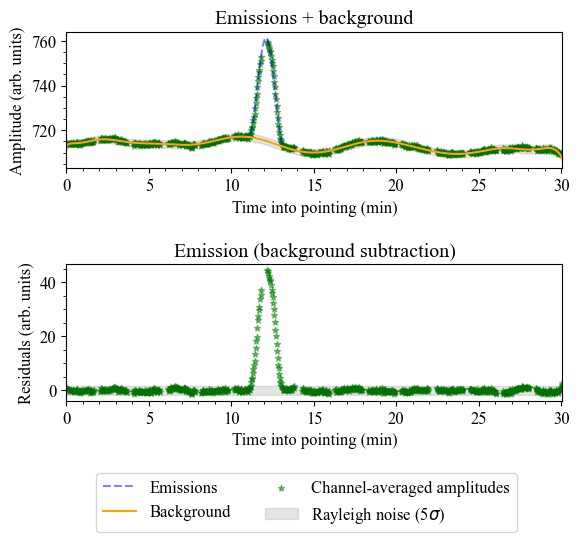

[ 1.50334632e+04  2.43247251e+01  1.02554738e+04  2.84924138e+01
  8.38137143e+03  1.58947268e+01  6.76215902e+03  1.46067499e+01
  3.41539527e+03  3.51574694e+00  6.41768805e+02  7.10639383e-01
  4.96492172e+01  1.63039761e+00  1.84099654e+00  7.24020626e+00
 -1.73770995e+00  6.91293364e-01 -1.99362089e+00 -2.55993676e+00
  4.61609386e+01  8.41051042e-03  7.43380884e-04]


In [ ]:
##Defining the function we now want to plot

def rcos_model(time, *params, show='all'):

    """ 
    The joint background + emissions model vs time.

    Args
    ----

    time:
        Time array to be plotted.
    
    params:
        Parameters consisting of concatenated DPSS coefficients + emission parameters arrays.

    show:
        If set to 'all', will return background + emissions. If set to 'background', will return background. If set to 'emit', will return emissions.
    
    Returns:
        background + emission, background only, or emission only, depending on the value of show.
    """
    N_terms=20
    coeff = params[:N_terms]
    theta = params[N_terms:]
    
    NW, K = 4, N_terms   
    basis = dpss(len(time), NW, K)
    design = basis.T
    
    background = design @ coeff

    emission = np.zeros_like(time)
    num_emissions = len(theta) // 3

    if len(theta) % 3 != 0:
        raise ValueError("Incorrect array size for Gaussian fit parameters.")

    for k in range(num_emissions):
        amp, mu, sigma = theta[3*k : 3*k + 3]
        mask = np.where(np.abs(time - mu) <= sigma, True, False)
        emission[mask] += amp / 2 * (1 + np.cos(np.pi*(time[mask] - mu)/sigma))
        
    if show == 'all':
        return background + emission
    elif show == 'emit':
        return emission
    elif show == 'background':
        return background

print(rcos_fit)
plt.style.use('default')
plt.rcParams.update({'font.size': 12,
                     'font.family': 'serif',
                     'font.serif': 'Times New Roman'})


##Plotting out our models and our data, plus our data minus the background model
figure, ax = plt.subplots(ncols=1, nrows=2)
ax[0].set_title("Emissions + background")
ax[0].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit), color='blue', alpha=0.5, linestyle='--', label='Emissions')
ax[0].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='background'), color='orange', alpha=1, label = 'Background')
ax[0].set_xlabel("Time into pointing (min)")
ax[0].set_ylabel("Amplitude (arb. units)")
ax[0].scatter(smooth_time*60*24, padded_amp, s=20, alpha=0.5, color='green', label='Channel-averaged amplitudes', marker='*')
ax[0].fill_between(smooth_time*60*24, 
                 -5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background') + rcos_model(smooth_time, *rcos_fit, show='background'),
                 5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background') + rcos_model(smooth_time, *rcos_fit, show='background'),
                 alpha = 0.1, color = 'black', label = r'Rayleigh noise (5$\sigma$)')
ax[0].set_xlim(smooth_time.min()*60*24, smooth_time.max()*60*24)
figure.legend(bbox_to_anchor=(0.5, -0.18), loc = 'lower center', ncol=2)
plt.subplots_adjust(hspace=0.7)

ax[1].set_title('Emission (background subtraction)')
ax[1].set_xlabel("Time into pointing (min)")
#ax[1].plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='emit'), color='blue', alpha=0.5, label = 'Emissions', linestyle='--')
ax[1].set_ylabel("Residuals (arb. units)")
ax[1].scatter(smooth_time*60*24, padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'), s=20, alpha=0.5, color='green', label='Residuals', marker='*')
ax[1].fill_between(smooth_time*60*24, 
                 -5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'),
                 5*np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'),
                 alpha = 0.1, color = 'black', label = r'Rayleigh noise (5$\sigma$)')
ax[1].set_xlim(smooth_time.min()*60*24, smooth_time.max()*60*24)

ax[0].minorticks_on()
ax[1].minorticks_on()
plt.show()

print(rcos_fit)

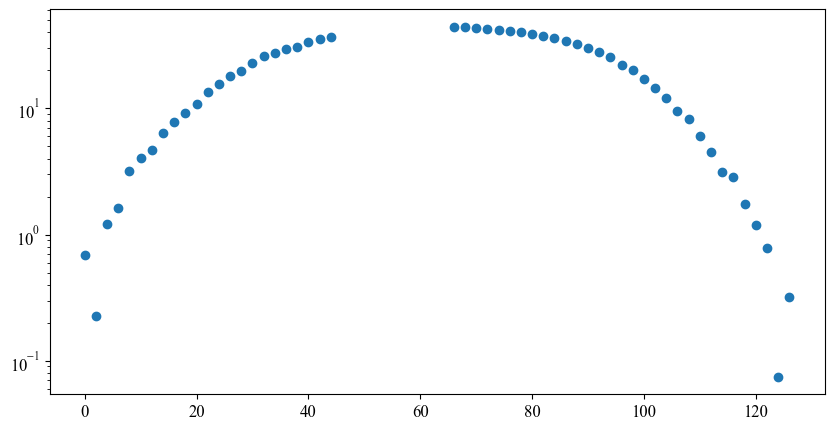

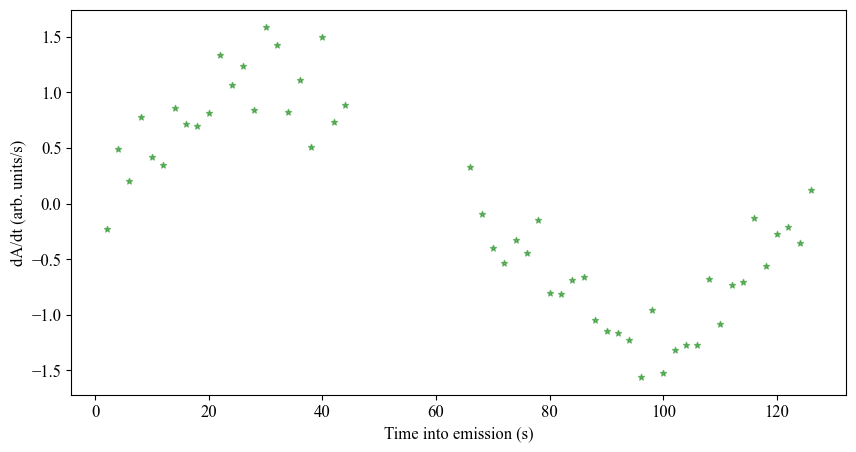

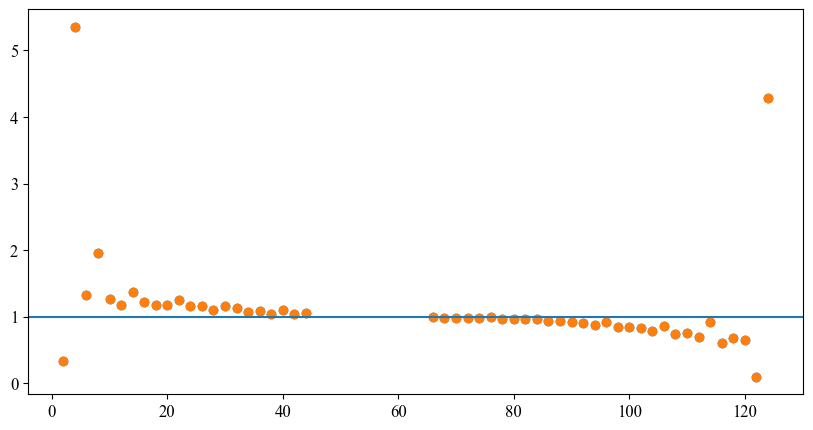

In [ ]:
#Looking at a singular emission. This cell is WIP

noise_cov = np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background')

emissions = np.where(rcos_model(smooth_time, *rcos_fit, show='emit') != 0, padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'), np.nan)

dadt = np.diff(emissions[np.isfinite(emissions)])/np.diff(smooth_time[np.isfinite(emissions)]*60*60*24)
#print(dadt)


new_mask = np.where(rcos_model(smooth_time, *rcos_fit, show='emit') != 0, False, True)
plt.figure(figsize=(10, 5))
plt.scatter((smooth_time[np.isfinite(emissions)] - smooth_time[np.isfinite(emissions)].min())*60*60*24, emissions[np.isfinite(emissions)])
plt.yscale('log')
plt.show()


plt.figure(figsize=(10, 5))
#plt.scatter(smooth_time[0:]*60*60*24, emissions, s=20, alpha=0.5, color='blue', label='Emissions', marker='*')
plt.scatter((smooth_time[np.isfinite(emissions)] - smooth_time[np.isfinite(emissions)].min())[1:]*60*60*24, dadt, s=20, alpha=0.5, color='green', label='Emission derivatives', marker='*')
plt.xlabel('Time into emission (s)')
plt.ylabel('dA/dt (arb. units/s)')
#plt.xlim(smooth_time.min()*60*60*24, smooth_time.max()*60*60*24)
#plt.scatter(smooth_time*60*24, padded_amp, s=20, alpha=0.5, color='green', label='Channel-averaged amplitudes', marker='*')
plt.show()

plt.figure(figsize=(10, 5))
plt.scatter((smooth_time[np.isfinite(emissions)] - smooth_time[np.isfinite(emissions)].min())[1:-1]*60*60*24, (emissions[1:]/emissions[:-1])[np.isfinite(emissions[1:]/emissions[:-1])])
plt.scatter((smooth_time[np.isfinite(emissions)] - smooth_time[np.isfinite(emissions)].min())[1:-1]*60*60*24, (emissions[1:]/emissions[:-1])[np.isfinite(emissions[1:]/emissions[:-1])])
plt.axhline(y=1)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


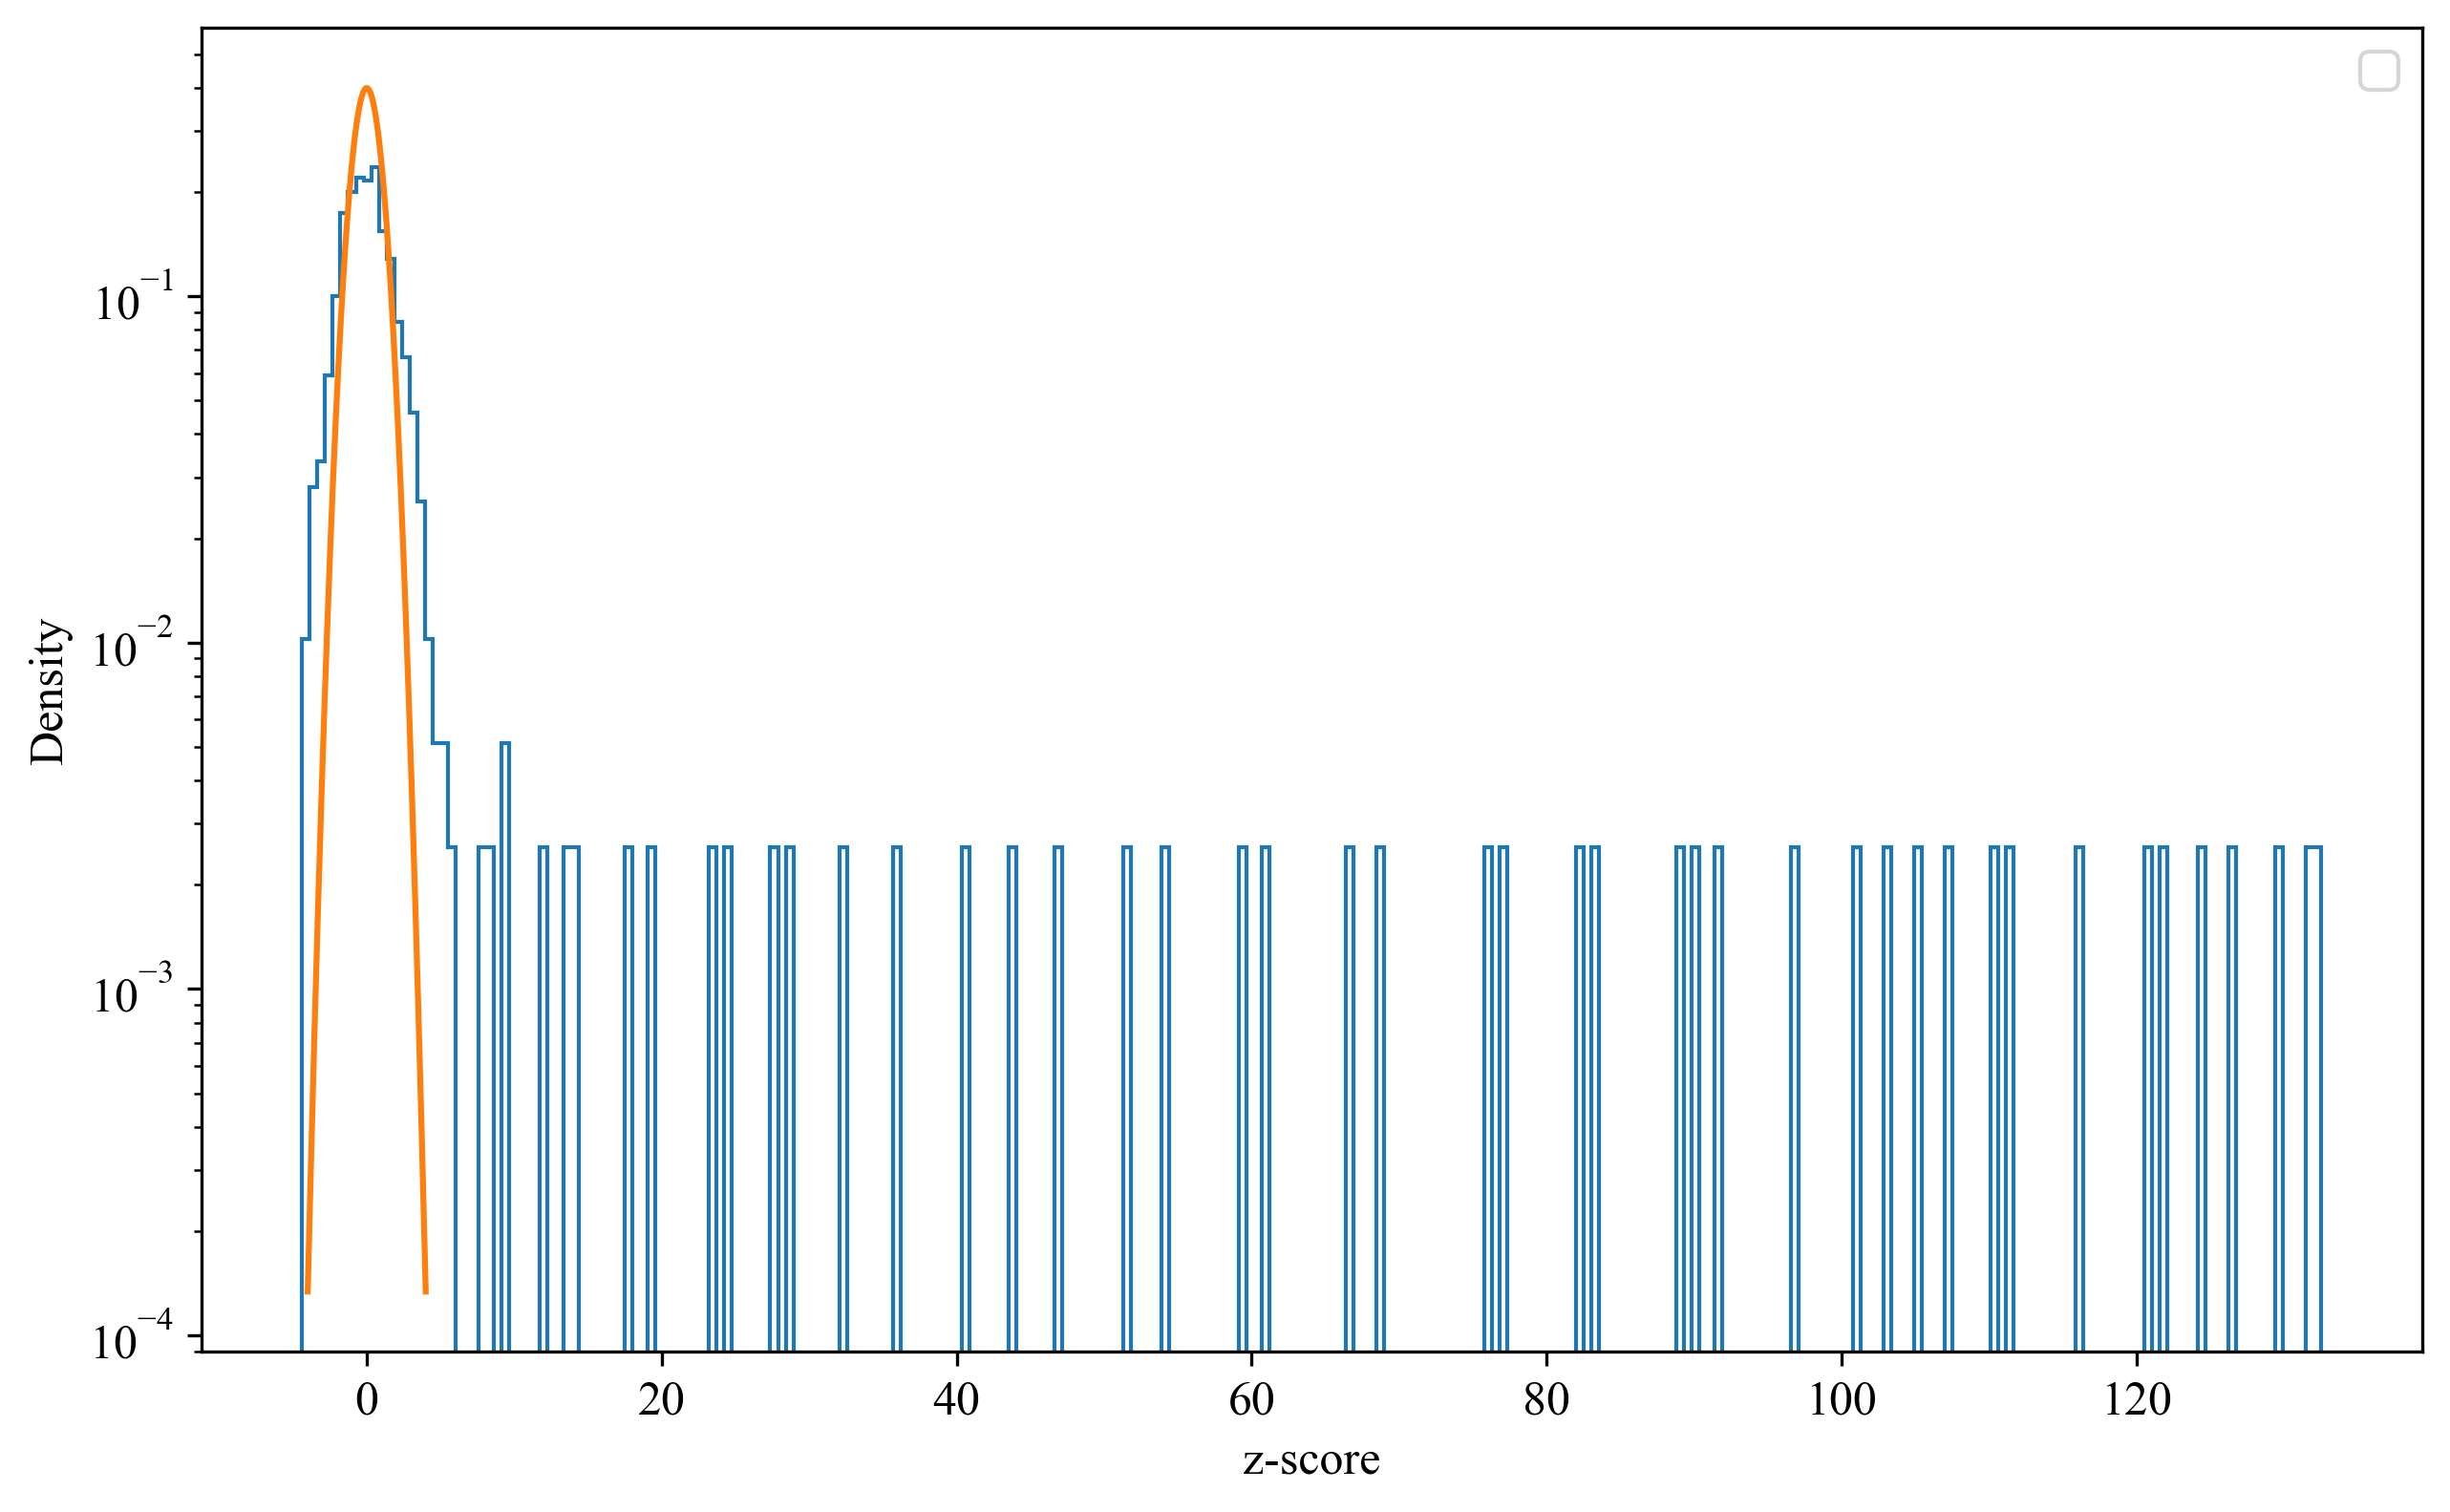

In [ ]:
#Testing out histograms for background subtracted data. Also WIP.

z_scores = (padded_amp - rcos_model(smooth_time, *rcos_fit, show='background'))/(np.sqrt((4/np.pi-1)/N_bl/N_freq)*rcos_model(smooth_time, *rcos_fit, show='background'))
z_scores = z_scores[np.isfinite(z_scores)]

x = np.linspace(-4, 4, 1000)


plt.figure(figsize=(10, 6), dpi=300)
plt.xlabel("z-score")
#plt.plot(smooth_time*60*24, rcos_model(smooth_time, *rcos_fit, show='emit'), color='orange', alpha=1, label = 'Emissions')
plt.ylabel("Density")
plt.hist(z_scores, bins='auto', histtype='step', density=True)
plt.plot(x, np.exp(-x**2/2)/np.sqrt(2*np.pi))
plt.yscale('log')
#plt.xlim(-4, 4)
plt.legend()
plt.show()